In [7]:
import numpy as np

ntsteps = 1

# Load data
predict = np.load("./Post_Proc_Data/membrane/inference_predictions.npy")  # shape = (batch_no, loc/vel, dataset_in_batch, n_nodes, timesteps, 3_directions)
nDataset = predict.shape[0]//ntsteps

data = np.zeros(shape=(nDataset,ntsteps,predict.shape[1],predict.shape[2]))
print("nDatapoints : ", nDataset)

l = 0 

for i in range(nDataset):
  data[i,:,:,:] = predict[l:l+ntsteps,:,:]
  l += ntsteps


coords = data[:, :, :, 0:3] + 20  # Extract coordinates
print(coords.shape)
vel = data[:, :, :, 3:6]  # Extract velocities
connect = np.load("connectivity.npy")  # Load connectivity data
# Define the Tecplot file writing function
def write_tecplot_dat(filename, coords, vel, connectivity):
  n_nodes = coords.shape[1]
  n_elements = connectivity.shape[0]

  for t in range(nDataset):
    with open(filename+'%i.dat'%t, 'w') as f:
      f.write('TITLE="3D TRIANGULAR SURFACE DATA"\n')
      f.write('VARIABLES="X","Y","Z"\n')
      f.write(f'ZONE T="unstruc" N={n_nodes} E={n_elements} F=FEPOINT ET=TRIANGLE\n')

      # Write node data
      for i in range(n_nodes):
        x, y, z = coords[t, i, :]
        u, v, w = vel[t, i, :]
        f.write(f'{x} {y} {z}\n')

      # Write connectivity data
      for conn in connectivity:
        f.write(f'{conn[0] + 1} {conn[1] + 1} {conn[2] + 1}\n')  # Tecplot uses 1-based indexing

# Write the data to a Tecplot .dat file
for n in range(ntsteps):   
  write_tecplot_dat("./Post_Proc_Data/membrane/memb_%i_"%n, coords[:,n,:,:], vel[:,n,:,:], connect)

nDatapoints :  100
(100, 1, 1757, 3)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [13]:
import vtk
from vtk.util.numpy_support import numpy_to_vtk
import os
import numpy as np
from sklearn.metrics import mean_absolute_error


"""
This is the script to visualize fluid data in paraview
"""
def save_vtk(predictions, output_folder):
  os.makedirs(output_folder, exist_ok=True)
  
  timestep_pred = predictions
  dimensions = timestep_pred.shape
  
  # Create VTK grid and set points
  points = vtk.vtkPoints()
  values = vtk.vtkDoubleArray()
  values.SetName("PredictedField")

  for z in range(dimensions[2]):
    for y in range(dimensions[1]):
        for x in range(dimensions[0]):
            points.InsertNextPoint(x, y, z)
            values.InsertNextValue(timestep_pred[x, y, z])

  grid = vtk.vtkStructuredGrid()
  grid.SetDimensions(dimensions)
  grid.SetPoints(points)
  grid.GetPointData().SetScalars(values)

  # Write to VTK file
  writer = vtk.vtkStructuredGridWriter()
  vtk_filename = os.path.join(output_folder, f"predicted_field_timestep_{t}.vtk")
  writer.SetFileName(vtk_filename)
  writer.SetInputData(grid)
  writer.Write()

  print(f"Saved {vtk_filename}")

ground_truth = np.load("./sample_data/data.npy")
print(ground_truth.shape)
ntsteps = ground_truth.shape[0]
nx = ground_truth.shape[2]
ny = ground_truth.shape[3]
nz = ground_truth.shape[4]

ground_truth = ground_truth[:,3,:,:,:]
fluid_prediction = np.load("./Post_Proc_Data/fluid/inference_predictions.npy")
fluid_prediction = fluid_prediction.reshape(fluid_prediction.shape[0], nx, ny, nz)

mae = mean_absolute_error(ground_truth.flatten(), fluid_prediction.flatten())
print(f"Mean Absolute Error (MAE): {mae}")

tstep = 1
sliceID = 0

for t in range(fluid_prediction.shape[0]):
    save_vtk(fluid_prediction[t,:,:,:],"./Post_Proc_Data/fluid/")

# In case a quick slice as to be viewed view it Extract the specific slice of data
# x = data[tstep, 0, :, :, :]
# y = data[tstep, 1, :, :, :]
# z = data[tstep, 2, :, :, :]
# vorticity = data[tstep, 3, :, :, sliceID]
# # Plot the contour
# plt.figure(1)
# contour = plt.contourf(x, y, vorticity, cmap='viridis')  # Use a colormap like 'viridis'
# plt.colorbar(contour)  # Add a color bar for reference
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Vorticity Contour')
# plt.show()

(201, 4, 70, 68, 59)
Mean Absolute Error (MAE): 0.19872484118714556
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_0.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_1.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_2.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_3.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_4.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_5.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_6.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_7.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_8.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_9.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_10.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_11.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_12.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_13.vtk
Saved ./Post_Proc_Data/fluid/predicted_field_timestep_14.vtk
Saved ./Post_Proc_Data/flui

In [1]:
"""
Code to generate data from .vti files

"""
import os
import numpy as np
import vtk
from vtk.util import numpy_support

# Directory containing the VTI files

def load_vti_file(file_name):
		reader = vtk.vtkXMLImageDataReader()
		reader.SetFileName(file_name)
		reader.Update()
		return reader.GetOutput()

def extract_data(image_data):
		X_array = image_data.GetPointData().GetArray("X")
		Y_array = image_data.GetPointData().GetArray("Y")
		Z_array = image_data.GetPointData().GetArray("Z")
		vorticity_array = image_data.GetPointData().GetArray("Vorticity")

		num_points = image_data.GetNumberOfPoints()
		print(num_points)
		X = np.zeros(num_points)
		Y = np.zeros(num_points)
		Z = np.zeros(num_points)
		vorticity = np.zeros(num_points)
		temperature = np.zeros(num_points)

		for i in range(num_points):
				# velocity = velocity_array.GetTuple(i)
				# u_array[i] = velocity[0]
				# v_array[i] = velocity[1]
				# w_array[i] = velocity[2]
				X[i] = X_array.GetValue(i)
				Y[i] = Y_array.GetValue(i)
				Z[i] = Z_array.GetValue(i)
				vorticity[i] = vorticity_array.GetValue(i)

		return X, Y, Z, vorticity

def reshape_arrays_to_grid(X, Y, Z, vorticity, temperature, x_res, y_res, z_res):
    x_reshaped = np.reshape(X, (z_res, y_res, x_res))
    y_reshaped = np.reshape(Y, (z_res, y_res, x_res))
    z_reshaped = np.reshape(Z, (z_res, y_res, x_res))
    vorticity_reshaped = np.reshape(vorticity, (z_res, y_res, x_res))
    return x_reshaped, y_reshaped, z_reshaped, vorticity_reshaped


vti_directory = '../sample_data/vtiData/'  # Change this to your VTI files directory
ntsteps = 100
nFeatures = 4
nx = 70
ny = 68
nz = 59

# file_name = vti_directory + "data_0.vti"
# image_data = load_vti_file(file_name)

# x, y, z, vorticity = extract_data(image_data)

# x = np.reshape(x, (nx, ny, nz), order='F')
# y = np.reshape(y, (nx, ny, nz), order='F')
# z = np.reshape(z, (nx, ny, nz), order='F')
# vorticity = np.reshape(vorticity, (nx, ny, nz), order='F')

# levels = np.linspace(0, 10, 11)

# plt.figure(figsize=(8, 6))
# plt.contourf(x[:, :, 50], y[:, :, 50], vorticity[:, :, 50], cmap='YlOrRd',levels=levels)
# plt.colorbar(label='Temperature (C)')
# plt.xlabel('X')
# plt.ylabel('Z')
# plt.title('Temperature Contour at y = 12')
# plt.grid(True)
# plt.axis('equal')
# plt.savefig("temp.png")


data_list = []
for tstep in range(ntsteps):
	file = vti_directory+"data_%i.vti"%tstep
	print(file)
	vtiData = load_vti_file(file)
	listData = extract_data(vtiData)
	arrayData = np.zeros(shape=(nFeatures,nx,ny,nz))

	for i in range(nFeatures):
		arrayData[i] = np.reshape(listData[i], (nx, ny, nz), order='F')
	
	data_list.append(arrayData)

data = np.array(data_list)
np.save('../sample_data/data.npy', data)


#     # Create a reader
#     reader = vtk.vtkXMLImageDataReader()
#     reader.SetFileName(os.path.join(vti_directory, file))
#     reader.Update()

#     # Get the output data object
#     imageData = reader.GetOutput()

#     # If data exists, extract it
#     if imageData:
#         # Extract the data arrays
#         num_arrays = imageData.GetPointData().GetNumberOfArrays()
#         temp_data = []
#         for i in range(num_arrays):
#             array = imageData.GetPointData().GetArray(i)
#             if array:
#                 np_array = numpy_support.vtk_to_numpy(array)
#                 # Reshape the array to match the grid dimensions (nx, ny, nz)
#                 dims = imageData.GetDimensions()
#                 np_array = np_array.reshape(dims)
#                 temp_data.append(np_array)

#         data_list.append(temp_data)

# # Convert list to numpy array, ensuring non-empty
# if data_list:
#     np_data = np.array(data_list)
# else:
#     np_data = np.array([])

# # Check shape - should be [ntsteps, nData, nx, ny, nz]
# print(np_data.shape)

# # Save the numpy array to a file
# np.save('./sample_data/data.npy', np_data)


../sample_data/vtiData/data_0.vti
280840
../sample_data/vtiData/data_1.vti
280840
../sample_data/vtiData/data_2.vti
280840
../sample_data/vtiData/data_3.vti
280840
../sample_data/vtiData/data_4.vti
280840
../sample_data/vtiData/data_5.vti
280840
../sample_data/vtiData/data_6.vti
280840
../sample_data/vtiData/data_7.vti
280840
../sample_data/vtiData/data_8.vti
280840
../sample_data/vtiData/data_9.vti
280840
../sample_data/vtiData/data_10.vti
280840
../sample_data/vtiData/data_11.vti
280840
../sample_data/vtiData/data_12.vti
280840
../sample_data/vtiData/data_13.vti
280840
../sample_data/vtiData/data_14.vti
280840
../sample_data/vtiData/data_15.vti
280840
../sample_data/vtiData/data_16.vti
280840
../sample_data/vtiData/data_17.vti
280840
../sample_data/vtiData/data_18.vti
280840
../sample_data/vtiData/data_19.vti
280840
../sample_data/vtiData/data_20.vti
280840
../sample_data/vtiData/data_21.vti
280840
../sample_data/vtiData/data_22.vti
280840
../sample_data/vtiData/data_23.vti
280840
..

In [2]:
np.save('./sample_data/data.npy', data)

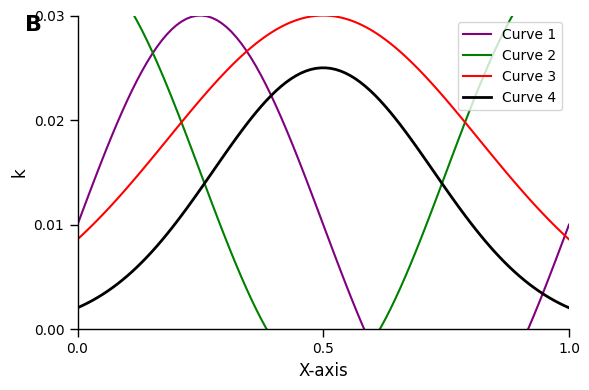

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data
x = np.linspace(0, 1, 100)
y1 = np.sin(2 * np.pi * x) * 0.02 + 0.01
y2 = np.cos(2 * np.pi * x) * 0.02 + 0.015
y3 = np.exp(-5 * (x - 0.5)**2) * 0.03
y4 = np.exp(-10 * (x - 0.5)**2) * 0.025

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot each curve with different colors and line widths
ax.plot(x, y1, color="purple", label="Curve 1", linewidth=1.5)
ax.plot(x, y2, color="green", label="Curve 2", linewidth=1.5)
ax.plot(x, y3, color="red", label="Curve 3", linewidth=1.5)
ax.plot(x, y4, color="black", label="Curve 4", linewidth=2)

# Customize axis appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set outward-facing ticks
ax.tick_params(direction='out', length=6, width=1)

# Add axis labels
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("k", fontsize=12)

# Set axis limits and ticks
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.03)
ax.set_xticks([0.0, 0.5, 1.0])
ax.set_yticks([0.00, 0.01, 0.02, 0.03])

# Add a bold annotation for "B"
fig.text(0.05, 0.95, "B", fontsize=16, fontweight="bold", va='top', ha='left')

# Add a legend
ax.legend(loc="upper right", fontsize=10)

# Adjust layout for a clean look
plt.tight_layout()
plt.show()
